# Using pandasGEXpress with .gct/x files 

--------------------------------------------------------------------------------
## A sample tutorial using data from [GEO GSE70138](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138)

Author: Oana Enache

Last updated April 26th, 2017

For questions and issue reports, please file an issue at github.com/cmap/cmapPy. 

--------------------------------------------------------------------------------

## Table of Contents

We have developed this tutorial to loosely follow a workflow we recommend for .gct/x files. 

[Background info](#background)

[Obtaining data from GEO](#getdata)

[Activate your conda environment](#conda)

[Parse in metadata only](#metadataparse)

[Parsing in a gct/x file](#parsegctx)

[Add/delete annotations](#annotations)

[Slicing gct/x files and GCToo instances](#slicing)

[Merging gct/x files](#merging)

[Construct a GCToo instance](#newGCToo)

[Using GCToo instances with pandas tools](#pandas)

[Plotting with GCToo objects](#plotting)

[Write a GCToo instance to file](#writing)

[Converting .gct <-> .gctx](#converting)

--------------------------------------------------------------------------------

<a id="background"></a>


## Background: What's .gct, .gctx, and GCToo? 

For more details on each of these topics, please visit clue.io/code. 


### The .gct format 

![Sample GCT file](GCT_mockup.png)

The GCT file format, a tab-delimited text-based format pairing matrix expression values with row and column metadata, allowing comparison of both transcriptional and contextual differences across samples. A mockup of a sample GCT file is pictured above. 

### The .gctx format

![Sample GCTX file](GCTX_mockup.png)

The GCTX file format was developed to improve serialization performance of GCT, particularly for large files. GCTX is an HDF5-based data format that can contain the same content as one or more GCT files in a hierarchically-structured, compressed, and easily accessible form (full file specification available at clue.io/code). Amongst other features, the HDF5 format allows users the ability to parse a subset of a large data set without reading the entire data set into memory first (using hyperslab selection) and the ability to easily add and remove data and metadata without the need to entirely re-write or restructure the original file. A mockup of a sample GCTX file is pictured above. 

### The GCToo object 

`GCToo` objects are instances of the GCToo class we developed to represent .gct and .gctx files in a form compatible with Python's [PANDAS](http://pandas.pydata.org/) library. In essence, GCToo is a container of 3 pandas DataFrames (optionally, can also include a multi-index DataFrame of these 3 DataFrames combined) as well as two attributes representing the file source and version respectively. For more information, please see [our documentation](http://cmappy.readthedocs.io/en/latest/pandasGEXpress.html#gctoo-class). 

<a id="getdata"></a>
## Obtaining Data from Gene Expression Omnibus (GEO)

[Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/), or GEO, is a NCBI-maintained public repository of array and sequence genomics data. As of April 2017, we have provided 1.7 million profiles to GEO at the following accessions:

* [GSE70138](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138)

* [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742)

* [GSE92743](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92743)

Please note that this does not represent the only data available in .gct and .gctx format; we simply mention it as a public resource for freely available data in these formats, and will use it as an example in this tutorial. 

Data can be downloaded from GEO using either using FTP or HTTP; see accession pages above for details.

<a id="conda"></a>
## Activate your cmapPy conda environment 

If you haven't done so already, [create a conda environment to use for your analyses](http://cmappy.readthedocs.io/en/latest/build.html).

For this example, we've named our conda environment ``my_cmapPy_env``. 

**Be sure to activate your environment before proceeding!**

``source activate my_cmapPy_env``

<a id="metadataparse"></a>
## Parse in metadata only 

Although we are in the process of developing tools to provide out of core functionality for larger that memory .gctx files, for now some .gctx files may be larger than the RAM you have available on your computer (note, we do not recommend the use of .gct for files above ~1000 samples). If this is the case, you have two options:

    1. Obtain access to a server/instance that has more RAM. 
    2. Read the metadata in first, find the sample (column) id values ("cids") that you're actually interested in, and only parse those cids in. 

### How to parse in metadata only from GEO

This would be applicable if you were interested in only certain samples (or certain compound names, cell types, etc). Here, we parse in the metadata from the level 5 (replicate-collapsed signature) data on GSE70138.

On GEO, because of submission requirements annotations file are stored as separate tab-delimited text files. For level 5 data, we're interested in the "sig" related data tables. For this example, we previously downloaded and unzipped "GSE70138_Broad_LINCS_sig_info_2017-03-06.txt.gz" (corresponding to identifying information about the samples; if you wanted metrics-related information for filtering, explore the equivalently labelled "sig metrics" file). 

Then, we read this in to a pandas DataFrame: 

In [14]:
import pandas as pd

sig_info = pd.read_csv("GSE70138_Broad_LINCS_sig_info_2017-03-06.txt", sep="\t")

In [15]:
# look at the metadata fields provided 
sig_info.columns

Index([u'Unnamed: 0', u'sig_id', u'pert_id', u'pert_iname', u'pert_type',
       u'cell_id', u'pert_idose', u'pert_itime'],
      dtype='object')

As an illustrative example, say we're only interested in looking at expression data corresponding to cells treated as vorinostat. So, we first want to find the sig_id values that correspond to vorinostat-treated samples:

In [22]:
# get all samples (across all cell types, doses, and other treatment conditions) that were treated with vorinostat
vorinostat_ids = sig_info["sig_id"][sig_info["pert_iname"] == "vorinostat"]
# how many samples are there in this data set?
print("number of samples treated with vorinostat:")
len(vorinostat_ids)

number of samples treated with vorinostat:


73908       LJP007_ASC_24H:A03
74633     LJP007_HUES3_24H:A03
74636    LJP007_MNEU.E_24H:A03
Name: sig_id, dtype: object

### Side note: How to parse in metadata only from a metadata-annotated gctx

Note. *This is not specifically relevant to the data available on GEO*, but if you have a .gctx file with row/column annotations and want to only look at the metadata annotations, you can also read only these fields in from the gctx. You would do this as follows:

``from cmapPy.pandasGEXpress import parse`` 

``gctx_metadata_only = parse("path/to/gctx.gctx", metadata_only=True)``

In [4]:
from cmapPy.pandasGEXpress import parse

my_col_metadata = parse("GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx", meta_only=True)

<a id="parsegctx"></a>
# Parse in a gctx

Now we're ready to read in expression data! For parsing, here are your options:

1. Read in an entire gctx file
2. Read in a subset of ids 

Generally, we recommend choice 2. We'll demonstrate how to do so here using the ``vorinostat_ids`` we obtained [in the previous section](#metadataparse). 

In [28]:
from cmapPy.pandasGEXpress import parse
vorinostat_only_gctoo = parse("GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx", cid=vorinostat_ids)

In [29]:
# Check to make sure we have all 210 colums of expression data: 
vorinostat_only_gctoo.data_df.shape #yup! 

(12328, 210)

Notes:

* If you did want to read in the entire file (option 1 above), you would just parse in the gct/x without the ``cid`` argument.
* Subsetting as demonstrated above is also available for row ids (rids). Here, this would correspond to only looking at certain genes of interest. 

<a id="annotations"></a>
## Add/delete annotations to an existing GCToo instance 

### Adding annotations
Now we have our sig_id annotations, and also a GCToo instance of expression data. This would probably be more useful to us as one unified object, so let's annotate our `vorinostat_only_gctoo` with the id information relevant to it: 

In [33]:
# first, we need to subset all the metadata information from our larger metadata DataFrame
vorinostat_sig_id_info =  sig_info[sig_info["pert_iname"] == "vorinostat"]
# let's look at a couple rows! 
vorinostat_sig_id_info[0:5]

,Unnamed: 0,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime
73908,73908,LJP007_ASC_24H:A03,BRD-K81418486,vorinostat,trt_cp,ASC,10.0 um,24 h
74633,74633,LJP007_HUES3_24H:A03,BRD-K81418486,vorinostat,trt_cp,HUES3,10.0 um,24 h
74636,74636,LJP007_MNEU.E_24H:A03,BRD-K81418486,vorinostat,trt_cp,MNEU.E,10.0 um,24 h
75013,75013,LJP007_NEU_24H:A03,BRD-K81418486,vorinostat,trt_cp,NEU,10.0 um,24 h
75379,75379,LJP007_NPC.CAS9_24H:A03,BRD-K81418486,vorinostat,trt_cp,NPC.CAS9,10.0 um,24 h


In [41]:
# to add this data as our col_metadata_df, 
# we need to first check that the sig_id column is the DataFrame index
vorinostat_sig_id_info.index # yup! 

Index([u'LJP007_ASC_24H:A03', u'LJP007_HUES3_24H:A03',
       u'LJP007_MNEU.E_24H:A03', u'LJP007_NEU_24H:A03',
       u'LJP007_NPC.CAS9_24H:A03', u'LJP007_NPC_24H:A03',
       u'LJP008_NEU_24H:A03', u'LJP008_NEU_24H:G07', u'LJP008_NEU_24H:G08',
       u'LJP008_NEU_24H:G09',
       ...
       u'LPROT002_NPC.TAK_6H:O10', u'LPROT002_NPC.TAK_6H:O12',
       u'LJP008_ASC_24H:A03', u'LJP008_ASC_24H:G07', u'LJP008_ASC_24H:G08',
       u'LJP008_ASC_24H:G09', u'LJP008_ASC_24H:G10', u'LJP008_ASC_24H:G11',
       u'LJP008_ASC_24H:G12', u'LJP007_SKL_24H:A03'],
      dtype='object', name=u'sig_id', length=210)

In [50]:
# let's the relevant annotations as a col_metadata_df: 
vorinostat_only_gctoo.col_metadata_df = vorinostat_sig_id_info
vorinostat_only_gctoo.col_metadata_df[0:5] 

,Unnamed: 0,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime
cid,,,,,,,
LJP007_ASC_24H:A03,73908,BRD-K81418486,vorinostat,trt_cp,ASC,10.0 um,24 h
LJP007_HUES3_24H:A03,74633,BRD-K81418486,vorinostat,trt_cp,HUES3,10.0 um,24 h
LJP007_MNEU.E_24H:A03,74636,BRD-K81418486,vorinostat,trt_cp,MNEU.E,10.0 um,24 h
LJP007_NEU_24H:A03,75013,BRD-K81418486,vorinostat,trt_cp,NEU,10.0 um,24 h
LJP007_NPC.CAS9_24H:A03,75379,BRD-K81418486,vorinostat,trt_cp,NPC.CAS9,10.0 um,24 h


### Deleting Annotations 

Hm, but now that we look at it we probably don't need the "pert_type" field; since we're only looking at vorinostat data, it's "trt_cp" (compound) for all samples. We could keep it anyway, but just for fun let's delete it: 

In [51]:
del vorinostat_only_gctoo.col_metadata_df["pert_type"]
vorinostat_only_gctoo.col_metadata_df[0:5]

,Unnamed: 0,pert_id,pert_iname,cell_id,pert_idose,pert_itime
cid,,,,,,
LJP007_ASC_24H:A03,73908,BRD-K81418486,vorinostat,ASC,10.0 um,24 h
LJP007_HUES3_24H:A03,74633,BRD-K81418486,vorinostat,HUES3,10.0 um,24 h
LJP007_MNEU.E_24H:A03,74636,BRD-K81418486,vorinostat,MNEU.E,10.0 um,24 h
LJP007_NEU_24H:A03,75013,BRD-K81418486,vorinostat,NEU,10.0 um,24 h
LJP007_NPC.CAS9_24H:A03,75379,BRD-K81418486,vorinostat,NPC.CAS9,10.0 um,24 h


<a id="slicing"></a> 
## Slicing GCToo instances 

Let's say that we're actually only interested in looking at vorinostat's signatures in A375 cells. First, are there vorinostat samples treated in this cell line in this GCToo instance? Let's check by first listing all unique cell lines present: 

In [54]:
vorinostat_only_gctoo.col_metadata_df["cell_id"].unique()

array(['ASC', 'HUES3', 'MNEU.E', 'NEU', 'NPC.CAS9', 'NPC', 'SKL', 'A375',
       'A549', 'PC3', 'ASC.C', 'CD34', 'HA1E', 'HCC515', 'HEPG2', 'HME1',
       'HT29', 'HUVEC', 'JURKAT', 'MCF7', 'NPC.TAK', 'SKL.C'], dtype=object)

Let's slice our GCToo instance to only include samples/columns corresponding to vorinostat-treated A375 cells.

In [63]:
from cmapPy.pandasGEXpress import slice_gct 

# first, get the cid values we want to keep 
vorinostat_a375_ids = vorinostat_only_gctoo.col_metadata_df.index[vorinostat_only_gctoo.col_metadata_df["cell_id"] == "A375"]

# slice GCToo instance to only include these values 
vorinostat_a375_gctoo = slice_gct.slice_gctoo(vorinostat_only_gctoo, cid=vorinostat_a375_ids)

# Now, our samples only correspond to one cell type: A375
vorinostat_a375_gctoo.col_metadata_df["cell_id"].unique()

array(['A375'], dtype=object)

Note that you can also slice by excluding rids/cids. For instance, if we wanted to include all cell lines **except** for A375, we could do so as follows: 

In [65]:
# slice vorinostat_only_gctoo to exclude A375 samples only
vorinostat_except_a375_gctoo = slice_gct.slice_gctoo(vorinostat_only_gctoo, exclude_cid=vorinostat_a375_ids)

# Now we have all cell lines except for A375: 
vorinostat_except_a375_gctoo.col_metadata_df["cell_id"].unique()

array(['ASC', 'HUES3', 'MNEU.E', 'NEU', 'NPC.CAS9', 'NPC', 'SKL', 'A549',
       'PC3', 'ASC.C', 'CD34', 'HA1E', 'HCC515', 'HEPG2', 'HME1', 'HT29',
       'HUVEC', 'JURKAT', 'MCF7', 'NPC.TAK', 'SKL.C'], dtype=object)

You could slice genes/rows of the GCToo analogously. 

<a link="merging"></a>
## Merging GCToo objects/.gct/.gctx files 

If you'd like to concatenate two or more objects/files, you have two options: 

1. Concatenate files from the command line 
2. Concatenate GCToo objects within a Python session. 

To continue with our GEO-based example, here we'll demonstrate option 2; for details on how to concatenate on the command line, please see [our documentation](http://cmappy.readthedocs.io/en/latest/pandasGEXpress.html).

### Concatenating GCToo objects in a Python session 

We have our vorinostat expression data in A375; let's say we want to also get belinostat expression data in A375 (separately, for purposes of demonstration) and then combine these two GCToos. First, some prep: let's get the belinostat expression data in A375 that we need to do this operation: 

In [102]:
# get sig info corresponding to belinostat-treated A375 samples
belinostat_a375_sig_info =  sig_info[(sig_info["pert_iname"] == "belinostat") & (sig_info["cell_id"] == "A375")]
# set sig_id as index 
belinostat_a375_sig_info.set_index("sig_id", inplace=True)
# parse in only expression data corresponding to belinostat-treated A375 samples
belinostat_a375_gctoo = parse("GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx", cid=belinostat_a375_sig_info.index)
# annotate belinostat_a375_gctoo with its corresponding sample annotations
belinostat_a375_gctoo.col_metadata_df = belinostat_a375_sig_info.copy()

And now we can concatenate our belinostat & vorinostat GCToos as follows:

In [115]:
from cmapPy.pandasGEXpress import concat_gctoo
# horizontally stack the two GCToo instances (note, you can also vertically stack)
# Somewhat confusingly, hstack concatenates samples together (same genes) and vstack does the opposite.
HDAC_a375_gctoo = concat_gctoo.hstack([vorinostat_a375_gctoo, belinostat_a375_gctoo])

# Now we have a gctoo corresponding to two compounds, in one cell line: 
print("unique compound data present: ") 
print(HDAC_a375_gctoo.col_metadata_df["pert_iname"].unique())
print("unique cell line data present: ")
print(HDAC_a375_gctoo.col_metadata_df["cell_id"].unique())

# Also note we still have the same genes as before, just with additional samples of data: 
print("combined gctoo expression data shape:")
print(HDAC_a375_gctoo.data_df.shape)

unique compound data present: 
['vorinostat' 'belinostat']
unique cell line data present: 
['A375']
combined gctoo expression data shape:
(12328, 33)


### Concatenating two .gct/x files on the command line

We provide the command line tool `concat_gctoo` to concatenate either .gcts or .gctx files on the command line. 

Sample usage: 

` concat_gctoo --concat_direction horiz --input_filepaths first_file.gct second_file.gct` will output a file named concated.gctx; you can specify a different outname if you prefer. On the command line, type `concat_gctoo -h` to see help options. 

<a id="newGCToo"></a>
## Constructing a new GCToo instance programatically 

If you have your own DataFrames of data, you can also construct your own GCToo instance (note that to do so, you need to fulfill the [requirements of a valid gctx](clue.io/code)). Just for illustrative purposes, let's make one using copies of our HDAC GCToo DataFrames, so that we can also associate a single [multi-index DataFrame](http://pandas.pydata.org/pandas-docs/stable/advanced.html) of our combined data_df, row_metadata_df, and column_data_df with this GCToo instance. 

**Note**: By default, the GCToo constructor does not make a multi_index_df; details on this and other optional arguments [here](http://cmappy.readthedocs.io/en/latest/pandasGEXpress.html#gctoo-class).

In [121]:
from cmapPy.pandasGEXpress import GCToo

HDAC_a375_gctoo_with_multiindex = GCToo.GCToo(data_df=HDAC_a375_gctoo.data_df.copy(), 
                                              row_metadata_df=HDAC_a375_gctoo.row_metadata_df.copy(), 
                                              col_metadata_df=HDAC_a375_gctoo.col_metadata_df.copy(), 
                                             make_multiindex=True)

# Let's take a look at a subset of this multiindex DataFrame; this can be useful for indexing etc.
HDAC_a375_gctoo_with_multiindex.multi_index_df[0:5]

,Unnamed: 0,95765,101778,101548,101549,101550,101551,101552,101553,101679,101680,...,112454,79548,79549,79550,2923,2924,2925,2926,2927,2928
,cell_id,A375,A375,A375,A375,A375,A375,A375,A375,A375,A375,...,A375,A375,A375,A375,A375,A375,A375,A375,A375,A375
,pert_id,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K17743125,BRD-K17743125,...,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K81418486,BRD-K17743125,BRD-K17743125,BRD-K17743125,BRD-K17743125,BRD-K17743125,BRD-K17743125
,pert_idose,10.0 um,10.0 um,10.0 um,3.33 um,1.11 um,0.37 um,0.12 um,0.04 um,10.0 um,3.33 um,...,1.0 um,1.0 um,1.0 um,1.0 um,10.0 um,3.33 um,1.11 um,0.37 um,0.12 um,0.04 um
,pert_iname,vorinostat,vorinostat,vorinostat,vorinostat,vorinostat,vorinostat,vorinostat,vorinostat,belinostat,belinostat,...,vorinostat,vorinostat,vorinostat,vorinostat,belinostat,belinostat,belinostat,belinostat,belinostat,belinostat
,pert_itime,24 h,24 h,24 h,24 h,24 h,24 h,24 h,24 h,24 h,24 h,...,6 h,6 h,6 h,6 h,24 h,24 h,24 h,24 h,24 h,24 h
,pert_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trt_cp,trt_cp,...,NaN,NaN,NaN,NaN,trt_cp,trt_cp,trt_cp,trt_cp,trt_cp,trt_cp
,cid,LJP007_A375_24H:A03,LJP008_A375_24H:A03,LJP008_A375_24H:G07,LJP008_A375_24H:G08,LJP008_A375_24H:G09,LJP008_A375_24H:G10,LJP008_A375_24H:G11,LJP008_A375_24H:G12,LJP008_A375_24H:L19,LJP008_A375_24H:L20,...,LPROT002_A375_6H:P11,LPROT003_A375_6H:P08,LPROT003_A375_6H:P10,LPROT003_A375_6H:P12,REP.A002_A375_24H:L19,REP.A002_A375_24H:L20,REP.A002_A375_24H:L21,REP.A002_A375_24H:L22,REP.A002_A375_24H:L23,REP.A002_A375_24H:L24
0,rid,,,,,,,,,,,,,,,,,,,,,
2,0,-0.404792,-0.9659,0.126108,0.151389,-0.017220,-0.913369,0.047228,-1.022178,0.066339,-0.69500,...,-0.4225,0.9135,-0.1148,1.2339,-2.487824,-2.429121,-0.0310,-1.117891,0.324044,-0.524321
9,1,2.393101,0.8664,0.370285,0.369526,0.182444,-0.401661,-0.979033,-0.353972,1.148439,-0.24320,...,1.6131,-1.2576,0.8574,0.4779,1.615412,0.250495,-1.1694,-0.260968,-0.521371,0.009504


For more information on multi-index DataFrames, please refer to the PANDAS project documentation. 

<a link="pandas"></a>
## Using pandas tools with your GCToo instance 

A big reason why we wrote `pandasGEXpress` was to enable users to maximize their use of `pandas`, `scikit-learn`, and other powerful and robustly-developed Python data science packages. Interacting with such tools simply requires referencing the relevant DataFrame attributes of your GCToo instance; here, we'll demonstrate how to do some basic arithmetic and grouping tasks on components of a GCToo instance. It should go without saying that the examples below are common but also fairly trivial examples of the wide functionality that libraries like pandas and sci-kit learn provide. 

Another `pandas` functionality that is likely to be of use is its `groupby` tools; as long as your data/annotations aren't too big, it can work nicely with your GCToo instance's `multi_index_df`.

### Column/row-wise means

Let's go back to our vorinostat-treated A375 cells. What is the mean expression across all samples? 

In [124]:
import pandas as pd 

vorinostat_a375_gctoo.data_df.mean(axis = 0) #easy-peasy

cid
LPROT003_A375_6H:P08    0.057203
LPROT003_A375_6H:P10    0.128851
LPROT003_A375_6H:P12    0.532979
LJP007_A375_24H:A03     0.622918
LJP008_A375_24H:G07     0.068805
LJP008_A375_24H:G08    -0.100531
LJP008_A375_24H:G09     0.012339
LJP008_A375_24H:G10    -0.228747
LJP008_A375_24H:G11    -0.034701
LJP008_A375_24H:G12    -0.113891
LJP008_A375_24H:A03     0.167949
LJP009_A375_24H:A03     0.351806
LPROT001_A375_6H:P07    0.163962
LPROT001_A375_6H:P09   -0.199321
LPROT001_A375_6H:P11    0.028832
LPROT002_A375_6H:P07   -0.050950
LPROT002_A375_6H:P09    0.146417
LPROT002_A375_6H:P11    0.150106
dtype: float32

If we wanted to determine the mean expression across all samples for individual genes, we would set axis=1. 

### Pairwise correlation of columns 

How correlated are our samples? 

In [130]:
vorinostat_a375_cors = vorinostat_a375_gctoo.data_df.corr()
vorinostat_a375_cors[0:5] #only showing first 5 rows 

cid,LPROT003_A375_6H:P08,LPROT003_A375_6H:P10,LPROT003_A375_6H:P12,LJP007_A375_24H:A03,LJP008_A375_24H:G07,LJP008_A375_24H:G08,LJP008_A375_24H:G09,LJP008_A375_24H:G10,LJP008_A375_24H:G11,LJP008_A375_24H:G12,LJP008_A375_24H:A03,LJP009_A375_24H:A03,LPROT001_A375_6H:P07,LPROT001_A375_6H:P09,LPROT001_A375_6H:P11,LPROT002_A375_6H:P07,LPROT002_A375_6H:P09,LPROT002_A375_6H:P11
cid,,,,,,,,,,,,,,,,,,
LPROT003_A375_6H:P08,1.000000,0.490662,0.532542,0.389154,0.320056,0.112311,-0.054310,-0.264264,-0.017371,-0.216171,0.224702,0.289866,0.259601,0.138528,0.301235,0.330139,0.479861,0.338621
LPROT003_A375_6H:P10,0.490662,1.000000,0.525302,0.419269,0.393848,0.122997,-0.049637,-0.235931,-0.097678,-0.251152,0.270517,0.334858,0.271433,0.161902,0.292011,0.343693,0.482537,0.436149
LPROT003_A375_6H:P12,0.532542,0.525302,1.000000,0.481375,0.284347,-0.064143,-0.093113,-0.440806,-0.040237,-0.379225,0.207452,0.349956,0.268879,0.035311,0.330700,0.217021,0.428786,0.359212
LJP007_A375_24H:A03,0.389154,0.419269,0.481375,1.000000,0.749817,0.065044,-0.160676,-0.324362,-0.159517,-0.358513,0.701374,0.879317,0.187186,0.074630,0.211691,0.274204,0.362895,0.332583
LJP008_A375_24H:G07,0.320056,0.393848,0.284347,0.749817,1.000000,0.260146,-0.069691,-0.129586,-0.174882,-0.182362,0.708696,0.720299,0.173727,0.199501,0.187436,0.355938,0.382282,0.383166


<a id="plotting"></a>
## Plotting with GCToo instances 

Because the attributes of a GCToo instance are pandas DataFrames, you can use any plotting libraries compatible with pandas DataFrames to generate plots; we frequently use [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/). For simple plots, pandas also provides built-in plotting functionality for DataFrame objects.  

As an illustrative example, we calculate the correlations across samples again, but this time also plot it as a heatmap--all in one!

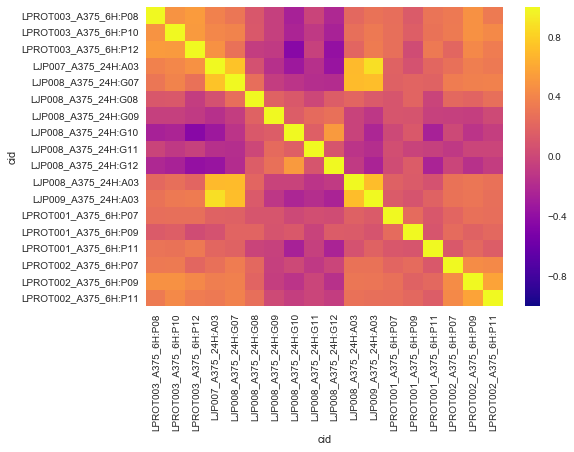

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


sns.heatmap(vorinostat_a375_gctoo.data_df.corr(), cmap='plasma')
plt.show()

<a id="writing"></a>
## Writing GCToo instances to file 

Here's how you would write your GCToo instance as a .gctx; note that if you'd like to write to .gct, the syntax is identical but you need to import ``write_gct`` instead. 

In [180]:
from cmapPy.pandasGEXpress import write_gctx as write_gctx

# write GCToo instance to .gctx
write_gctx.write(belinostat_a375_gctoo, "belinostat_a375")

<a id="converting"></a>
## Converting .gct <-> .gctx 

Converting from a gct to a gctx might be useful if you have a large gct and want faster IO in the future. We provide the following command line tools to do so: 

* `gct2gctx`
* `gctx2gct`

**To write some_thing.gct -> some_thing.gctx:**

gct2gctx -filename path/to/in_name.gct -output_filepath /path/to/out_name

Converting a gctx to a gct might be useful if you want to look at your .gctx file in a text editor or something similar. 

**To write some_thing.gctx -> some_thing.gct in working directory:**

gctx2gct -filename path/to/in_name.gctx -output_filepath /path/to/out_name
